In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import PatchExtractor as PE
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = True):
    clf = linear_model.Lasso(alpha=0.000001, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)
    
    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                print("not enough data!\n")
                #print(i)
                continue
            #elif len(rm) == ps1*ps2:
                #recdata[i,:] = data[i,:]
                #continue
        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = True):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    print(patch_size)
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    print("shape of data",data.shape)
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

In [ ]:
img=mean(imread('catODE.png'),-1)[::2,::2]

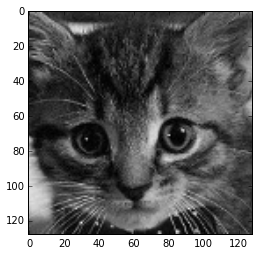

In [ ]:
imshow(img,cmap = plt.get_cmap("binary_r"))
savefig("cat_128x128.pdf")

In [ ]:
ps=8
pe = PE((ps,ps))
patches = reshape(pe.transform(array([img])),(-1,ps*ps),order='C')

In [ ]:
tempdic = MiniBatchDictionaryLearning(n_components=100, alpha=0.1, n_iter=10000 )
V = tempdic.fit(patches).components_

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


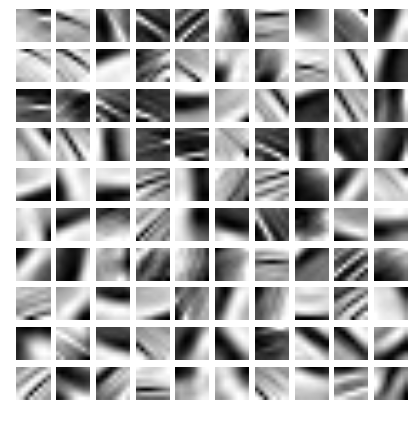

In [ ]:
cmp = plt.get_cmap("binary_r")
fig =plt.figure(figsize=(7,7))
for i,comp in enumerate(V):
    subplot(10,10,i+1)
    imshow(reshape(comp,(ps,ps)),cmap = cmp)
    #tick_params(bottom='none',left='none')
    plt.axis('off')    
savefig("catbasis_8x8.pdf")    

In [ ]:
imgc =np.full((128,128),0.)
imgc[:] = img[:]

In [ ]:
imgc[np.random.rand(128,128)<0.7]=-100.

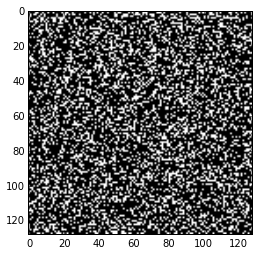

In [ ]:
imshow(imgc,cmap = plt.get_cmap("binary_r"))

In [ ]:
imgc_rec = image_rec(imgc,V,1,8,8)

(8, 8)
shape of data (14641, 64)


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


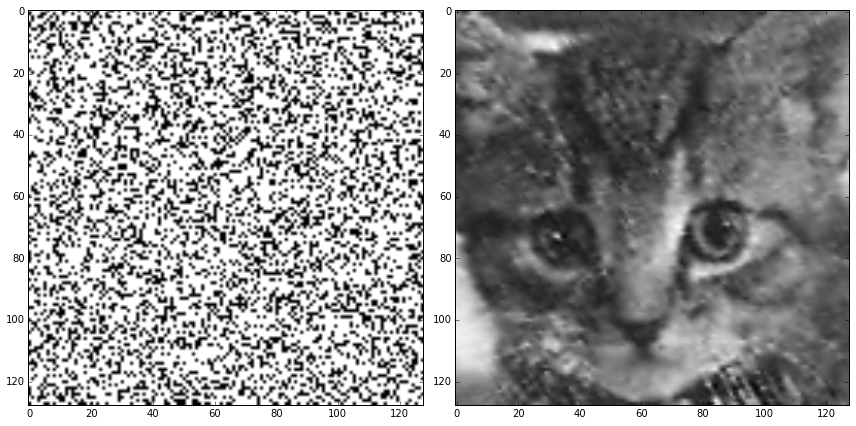

In [ ]:
figure(figsize=(12,6))
subplot(1,2,1)
imshow(imgc,cmap = plt.get_cmap("binary"))
subplot(1,2,2)
imshow(imgc_rec,cmap = plt.get_cmap("binary_r"))
tight_layout()
savefig("cat_rec.pdf")  